# Example 1: Collett

Example 1 comes from a placebo-controlled trial on time-to-recurrence among bladder cancer patients, with data obtained from Collett. Data consists of 86 patients  who received either placebo or the chemotherapeutic thiotepa following removal of superficial bladder tumors, with time measured in months up to $\tau = 59$. Other baseline variables collected included the initial number of tumors and the diameter (in centimeters) of the largest initial tumor. Here, the parameter of interest was the average causal effect comparing novel to standard treatment on disease-free survival at 59 months. While treatment was randomized, both number of tumors and tumor diameter are adjusted for. Both variables were modeled as linear relationships for simplicity. Time was modeled using disjoint indicators and restricted quadratic splines with knots at 10, 20, 30, and 40 months, respectively.

## Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from time import time
import delicatessen as deli
from delicatessen import MEstimator
from delicatessen.utilities import spline

from efuncs import ee_pooled_logit, pooled_logit_prediction

print("NumPy version:       ", np.__version__)
print("SciPy version:       ", sp.__version__)
print("Pandas version:      ", pd.__version__)
print("Matplotlib version:  ", matplotlib.__version__)
print("Delicatessen version:", deli.__version__)

NumPy version:        1.25.2
SciPy version:        1.11.2
Pandas version:       1.4.1
Matplotlib version:   3.9.2
Delicatessen version: 3.1


In [2]:
d = pd.read_csv("data/collett.dat", sep='\s+',
                names=['patient', 'time', 'delta', 'treat', 'init', 'size'])
d['novel'] = d['treat'] - 1
d['intercept'] = 1

# Data under policy
d1 = d.copy()
d1['novel'] = 1
d0 = d.copy()
d0['novel'] = 0

In [3]:
a = np.asarray(d['novel'])
t = np.asarray(d['time'])
y = np.asarray(d['delta'])
W = np.asarray(d[['init', 'size', ]])

## Fitting Treatment-Stratified Pooled Logistic Models

To begin, we illustrate how stratified pooled logistic regression models are fit. Here, models are stratified by treatment, which avoids a proportional hazards assumption for treatment, and also incorporates interactions between treatment and other baseline variables. 

### Disjoint Indicators for Time

Starting with $A=1$, a pooled logistic model can be estimated via

In [4]:
# Unique events times for A=1
event_times_a1 = list(np.unique(d.loc[(d['delta'] == 1) & (d['novel'] == 1), 'time']))
params_plr_a1 = len(event_times_a1)

In [5]:
def psi_plogit_a1(theta):
    ee_plog = ee_pooled_logit(theta, t=t, delta=y, X=W, unique_times=event_times_a1)
    ee_plog = ee_plog * (a == 1)[None, :]
    return ee_plog

In [6]:
inits = ([0., ]*W.shape[1] + [-4., ] +   # Coefs for baseline vars
         [0., ]*(params_plr_a1 - 1))     # Coefs for time terms
estr = MEstimator(psi_plogit_a1, init=inits)
estr.estimate()

In [7]:
beta_x = estr.theta[:W.shape[1]]
beta_s = estr.theta[W.shape[1]:]
print(beta_x)
print(beta_s)

[ 0.25870155 -0.18195973]
[-3.31904188  0.89147013 -0.45786535  0.30725113 -0.29018937  0.63019414
  0.83450915  0.27667163  0.38896891  0.6490591   0.95004305]


The same process can be applied for $A=0$, illustrated below

In [8]:
# Unique events times for A=0
event_times_a0 = list(np.unique(d.loc[(d['delta'] == 1) & (d['novel'] == 0), 'time']))
params_plr_a0 = len(event_times_a0)

# Defining estimating function
def psi_plogit_a0(theta):
    ee_plog = ee_pooled_logit(theta, t=t, delta=y, X=W, unique_times=event_times_a0)
    ee_plog = ee_plog * (a == 0)[None, :]
    return ee_plog

# Applying M-estimator procedure
inits = ([0., ]*W.shape[1] + [-4., ] +   # Coefs for baseline vars
         [0., ]*(params_plr_a0 - 1))     # Coefs for time terms
estr = MEstimator(psi_plogit_a0, init=inits)
estr.estimate()

# Showing results
beta_x = estr.theta[:W.shape[1]]
beta_s = estr.theta[W.shape[1]:]
print(beta_x)
print(beta_s)

[0.32501568 0.19662417]
[-5.00658799  1.60816912  2.39202803  1.16089777  1.21710273  0.60349059
  1.40959494  0.75270757  1.62960972  0.98311     1.09439099  1.20492737
  1.4032226   1.52463914  1.66612369  2.56839092]


### Splines for Time

Rather than modeling time with disjoint indicators, one can also use parametric function forms. Here, we use restricted quadratic splines

In [9]:
# Creating time design matrix
t_steps = np.asarray(range(1, 60))
intercept = np.ones(t_steps.shape)[:, None]
time_splines = spline(t_steps, knots=[10, 20, 30, 40],
                      power=2, restricted=True, normalized=False)
s_matrix = np.concatenate([intercept, t_steps[:, None], time_splines], axis=1)

In [10]:
def psi_plogit_spline_a1(theta):
    ee_plog = ee_pooled_logit(theta=theta, t=t, delta=y, X=W, S=s_matrix)
    ee_plog = ee_plog * (a == 1)[None, :]
    return ee_plog

In [11]:
inits = [0., 0., -4., ] + [0., ]*4
estr = MEstimator(psi_plogit_spline_a1, init=inits)
estr.estimate()

In [12]:
beta_x = estr.theta[:W.shape[1]]
beta_s = estr.theta[W.shape[1]:]
print(beta_x)
print(beta_s)

[ 0.26073188 -0.20114176]
[-2.54004996 -0.2109608   0.02323001 -0.04671061  0.03258718]


Again, the same process can be applied for $A=0$

In [13]:
def psi_plogit_spline_a0(theta):
    ee_plog = ee_pooled_logit(theta=theta, t=t, delta=y, X=W, S=s_matrix)
    ee_plog = ee_plog * (a == 0)[None, :]
    return ee_plog


# Applying M-estimator procedure
inits = [0., 0., -4., ] + [0., ]*4
estr = MEstimator(psi_plogit_spline_a0, init=inits)
estr.estimate()

# Showing results
beta_x = estr.theta[:W.shape[1]]
beta_s = estr.theta[W.shape[1]:]
print(beta_x)
print(beta_s)

[0.28674963 0.1763097 ]
[-3.37476252e+00 -8.17811188e-02  9.19681517e-04  1.27216992e-02
 -5.63928001e-02]


## Estimating the Risk Difference

The pooled logistic regression model is simply a nuisance model for the parameters were are interested in. Here, we apply the g-computation estimator to obtain the marginal risk differences. To simply writing the function, we call the previously defined pooled logistic model functions

### Disjoint Indicators for Time

First, consider how the disjoint indicators for time can be used to model the risk difference over follow-up

In [14]:
# Counting up events to define number of parameters later
event_times = [0, ] + list(np.unique(d.loc[d['delta'] == 1, 'time'])) + [59, ]
event_times_a1 = list(np.unique(d.loc[(d['delta'] == 1) & (d['novel'] == 1), 'time']))
event_times_a0 = list(np.unique(d.loc[(d['delta'] == 1) & (d['novel'] == 0), 'time']))
params_rd = len(event_times)
params_plr_a1 = len(event_times_a1)
params_plr_a0 = len(event_times_a0)

In [15]:
def psi_rd(theta):
    # Extracting parameters
    rds = theta[:params_rd]
    idPLR = params_rd + W.shape[1] + params_plr_a1
    beta1 = theta[params_rd: idPLR]
    beta0 = theta[idPLR:]

    # Nuisance models
    ee_plog1 = psi_plogit_a1(theta=beta1)
    ee_plog0 = psi_plogit_a0(theta=beta0)

    # Predictions to get risk differences
    risk1 = pooled_logit_prediction(theta=beta1, delta=y, t=t, X=W,
                                    times_to_predict=event_times, measure='risk', 
                                    unique_times=event_times_a1)
    risk0 = pooled_logit_prediction(theta=beta0, delta=y, t=t, X=W,
                                    times_to_predict=event_times, measure='risk', 
                                    unique_times=event_times_a0)
    ee_rd = (risk1 - risk0) - np.asarray(rds)[:, None]

    # Returning stacked estimating equations
    return np.vstack([ee_rd, ee_plog1, ee_plog0])

In [16]:
inits = ([0., ]*params_rd
         + [0., ]*W.shape[1] + [-4., ] + [0., ]*(params_plr_a1 - 1)
         + [0., ]*W.shape[1] + [-4., ] + [0., ]*(params_plr_a0 - 1))
estr = MEstimator(psi_rd, init=inits)
estr.estimate()

In [17]:
# Formatting RD results for figure
rd = estr.theta[:params_rd]
rd_ci = estr.confidence_intervals()[:params_rd, :]
rd_results = pd.DataFrame()
rd_results['time'] = event_times
rd_results['rd'] = rd
rd_results['lcl'] = rd_ci[:, 0]
rd_results['ucl'] = rd_ci[:, 1]

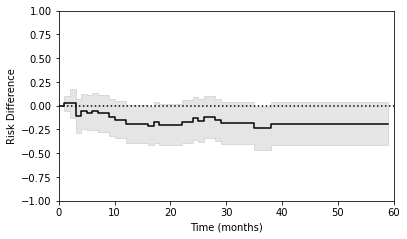

In [18]:
fig, ax = plt.subplots(figsize=[6, 3.5])
ax.axhline(y=0, linestyle=':', color='k')
ax.fill_between(rd_results['time'], rd_results['lcl'], rd_results['ucl'], color='k', alpha=0.1, step='post')
ax.step(rd_results['time'], rd_results['rd'], color='k', where='post')
ax.set_xlim([0, 60])
ax.set_ylim([-1, 1])
ax.set_xlabel("Time (months)")
ax.set_ylabel("Risk Difference")
plt.show()

### Splines for Time

Repeating estimation of the risk difference but with splines for time.

In [19]:
tp_intervals = list(range(0, 60))
params_risk = len(tp_intervals)

In [20]:
def psi_rd(theta):
    # Extracting parameters
    risks = theta[:params_risk]
    idPLRM = params_risk + 7
    beta1 = theta[params_risk:idPLRM]
    beta0 = theta[idPLRM:]

    # Nuisance models
    ee_plog1 = psi_plogit_spline_a1(theta=beta1)
    ee_plog0 = psi_plogit_spline_a0(theta=beta0)

    # Predictions to get risk differences
    risk1 = pooled_logit_prediction(theta=beta1, t=t, delta=y, X=W, S=s_matrix,
                                    times_to_predict=tp_intervals, measure='risk')
    risk0 = pooled_logit_prediction(theta=beta0, t=t, delta=y, X=W, S=s_matrix,
                                    times_to_predict=tp_intervals, measure='risk')
    ee_rd = (risk1 - risk0) - np.asarray(risks)[:, None]

    # Returning stacked estimating equations
    return np.vstack([ee_rd, ee_plog1, ee_plog0])

In [21]:
inits = [0., ]*params_risk + [0., 0., -4., ] + [0., ]*4 + [0., 0., -4., ] + [0., ]*4
estr = MEstimator(psi_rd, init=inits)
estr.estimate()

In [22]:
rd_results = pd.DataFrame()
rd_results['time'] = tp_intervals
rd_results['rd'] = estr.theta[:params_risk]
rd_ci = estr.confidence_intervals()[:params_risk, :]
rd_results['lcl'] = rd_ci[:, 0]
rd_results['ucl'] = rd_ci[:, 1]

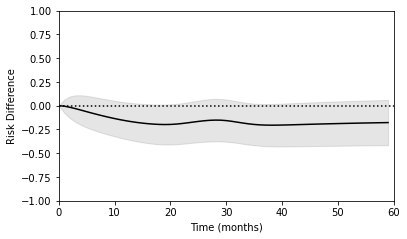

In [23]:
fig, ax = plt.subplots(figsize=[6, 3.5])
ax.axhline(y=0, linestyle=':', color='k')
ax.fill_between(rd_results['time'], rd_results['lcl'], rd_results['ucl'], color='k', alpha=0.1)
ax.plot(rd_results['time'], rd_results['rd'], color='k')
ax.set_xlim([0, 60])
ax.set_ylim([-1, 1])
ax.set_xlabel("Time (months)")
ax.set_ylabel("Risk Difference")
plt.show()

This completes the walkthrough of the example. If you wish to view the code for how the figures for the publication were generated or the timing between different implementations, please see the corresponding files described in the README.